10/23/2019

# About
Note, for all ReFeX features, we used the unionized features.

In [1]:
from __future__ import division
import os
import os
import itertools
#import community
from datetime import datetime, timedelta
from sklearn.model_selection import RandomizedSearchCV


folder_directory =os.getcwd()
os.chdir(folder_directory)
execfile('python_libraries.py')
execfile('parsing.py')  # Sam Way's Code
execfile('mixing.py')   # Sam Way's Code
execfile('create_adjacency_matrix.py')
execfile('LINK.py')


np.seterr(divide='ignore', invalid='ignore')

/Users/kristen/anaconda3/envs/ipykernel_py2/lib/python2.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


{'divide': 'warn', 'invalid': 'warn', 'over': 'warn', 'under': 'ignore'}

In [2]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))


# Across-Network (Replicate RolX Results + Baseline)


In [3]:
## 8/21/2018 - set up logforest model
from sklearn.ensemble import BaggingClassifier

In [4]:
subset_dates = np.array(['7_2004.csv',
                        '8_2004.csv',
                        '9_2004.csv',
                        '10_2004.csv',
                        '11_2004.csv',
                        '12_2004.csv',
                        '1_2005.csv',
                        '2_2005.csv',
                        '3_2005.csv',
                        '4_2005.csv',
                        '5_2005.csv',
                        '6_2005.csv'])

### AUC

In [6]:
RF = True # else continues using LogForest models from earlier
undersampling = False # implements balanced RF
from sklearn.model_selection import RandomizedSearchCV


In [9]:
## redo
y = pd.read_csv('../../data/RealityMining/convert_bluetooth_nw/by_month/labels.csv')

class_type = 'sloan' # mlgrad sloan

if class_type =='sloan':
    y['y']=((y.affil_clean=='sloan') | (y.affil_clean=='sloan_2'))+0
if class_type == 'mlgrad':
    y['y']=((y.affil_clean=='mlgrad') | (y.affil_clean=='1styeargrad') | (y.affil_clean=='grad '))+0


df_results = pd.DataFrame()
undersample = False


for iter_type in np.array([100,1,2,3]):
    print 'iter: ', iter_type
    print type(iter_type)
    
    ## accuracy
    acc_generic = []
    acc_generic_refex_predict = []

    ## auc
    auc_generic = []
    auc_generic_refex_predict = []


    

    for j in range(len(subset_dates)-1):
        if iter_type == 1:
            x_train = pd.read_csv('../refex-rolx-master-1/RM-data/out_union_0.5_RealityMining_'+subset_dates[j]+'-featureValues.csv', header = -1)
            x_test = pd.read_csv('../refex-rolx-master-1/RM-data/out_union_0.5_RealityMining_'+subset_dates[j+1]+'-featureValues.csv', header = -1)
        if iter_type == 2:
            x_train = pd.read_csv('../refex-rolx-master-2/RM-data/out_union_0.5_RealityMining_'+subset_dates[j]+'-featureValues.csv', header = -1)
            x_test = pd.read_csv('../refex-rolx-master-2/RM-data/out_union_0.5_RealityMining_'+subset_dates[j+1]+'-featureValues.csv', header = -1)
        if iter_type == 3:
            x_train = pd.read_csv('../refex-rolx-master-3/RM-data/out_union_0.5_RealityMining_'+subset_dates[j]+'-featureValues.csv', header = -1)
            x_test = pd.read_csv('../refex-rolx-master-3/RM-data/out_union_0.5_RealityMining_'+subset_dates[j+1]+'-featureValues.csv', header = -1)
        if iter_type == 100:
            x_train = pd.read_csv('../refex-rolx-master/RM-data/out_union_0.5_RealityMining_'+subset_dates[j]+'-featureValues.csv', header = -1)
            x_test = pd.read_csv('../refex-rolx-master/RM-data/out_union_0.5_RealityMining_'+subset_dates[j+1]+'-featureValues.csv', header = -1)
 


        
        ##
        ## Baseline Classifier -- based on relative training proportions
        ## 
        
        df_train = pd.DataFrame({'id':np.array(map(np.int,x_train[0]))})
        df_test = pd.DataFrame({'id':np.array(map(np.int,x_test[0]))})

        y_train = df_train.merge(y[['id','y']],
                how = 'left',
                on = 'id')

        y_test = df_test.merge(y[['id','y']],
            how = 'left',
            on = 'id')

        num1 = np.sum(y_train.y==1)
        num0 = np.sum(y_train.y==0)
        if num1 > num0:
            label = 1
        else:
            label = 0


        y_predict = np.repeat(label,len(y_test))
        y_true = np.array(y_test.y)

        acc_generic.append(np.mean(y_true == y_predict))
        
        
        auc_generic.append(metrics.roc_auc_score(label_binarize(y_true,np.unique(y_true)),
                                                                            y_predict,average='weighted'))

        ## 1st column is an IDs column -- we drop
        x_train = x_train.loc[:,1::]
        x_test = x_test.loc[:,1::]
        
        
        ## next we need to align columns -- want intersection set of columns that are in both training and test months
        if iter_type == 100:
            x_train_names = pd.read_csv('../refex-rolx-master/RM-data/union_unique_featureNames.csv')
            x_test_names = pd.read_csv('../refex-rolx-master/RM-data/union_unique_featureNames.csv')

        if iter_type == 1 or iter_type == 2 or iter_type ==3:
            x_train_names = pd.read_csv('../refex-rolx-master-'+str(iter_type) +'/RM-data/union_unique_featureNames.csv')
            x_test_names = pd.read_csv('../refex-rolx-master-'+str(iter_type) +'/RM-data/union_unique_featureNames.csv')


        
        scaler.fit(x_train)
        x_train = scaler.transform(x_train)

        scaler.fit(x_test)
        x_test = scaler.transform(x_test)
        
        
        x_train_m = pd.DataFrame(np.matrix(x_train))
        x_test_m = pd.DataFrame(np.matrix(x_test))
        x_train_m.columns = np.array(x_train_names.columns)
        x_test_m.columns = np.array(x_test_names.columns)

        arg_sort_idx = np.array(x_train_m.columns).argsort()
        x_train_m = x_train_m.iloc[:,arg_sort_idx]
        x_test_m = x_test_m.iloc[:,arg_sort_idx]
        num_features = np.shape(x_train_m)[1]

        model = BaggingClassifier(linear_model.LogisticRegression(penalty='l2',
                                                solver='lbfgs',
                                                C=10e20),
                               n_estimators=500,
                              max_features=np.int(np.round(np.log(np.shape(x_train)[1])))+1)

            
        if RF:
            if undersampling:
                ## add in -- undersampling possibly
                max_depth = [3, 5, 10]
                max_depth.append(None)
                min_samples_leaf = [1,5]#[0.05, 0.1, 0.2]
                min_samples_split = [2,5] #[2, 3, 4, 5, 10]
                n_estimators = [50, 100, 1000]#150]
                max_features = ['auto', 0.25, 0.5, 0.75]
                random_grid = {'max_depth': max_depth,
                                'min_samples_leaf': min_samples_leaf,
                                'max_features': max_features,
                                'n_estimators': n_estimators,
                                'min_samples_split': min_samples_split
                                }

                clf = sklearn.ensemble.RandomForestClassifier()
                pipeline = imbPipeline([('undersample', imblearn.under_sampling.RandomUnderSampler(random_state=567)),
                                            #('oversample',imblearn.over_sampling.SMOTE()), 
                                    ('clf',clf)])
                model = RandomizedSearchCV(estimator = pipeline,
                        param_distributions = random_grid,
                        cv = 3, verbose=0,
                        n_jobs = 2)

            else:
                max_depth = [3, 5, 10]
                max_depth.append(None)
                min_samples_leaf = [1]#[0.05, 0.1, 0.2]
                min_samples_split = [2] #[2, 3, 4, 5, 10]
                n_estimators = [100, 1000]#150]
                max_features = ['auto', 0.25, 0.5, 0.75]
                random_grid = {'max_depth': max_depth,
                                'min_samples_leaf': min_samples_leaf,
                                'max_features': max_features,
                                'n_estimators': n_estimators,
                                'min_samples_split': min_samples_split,
                               'class_weight': [{1:0.505, 1:50.5},{1:0.51, 1:25.5},{1:0.525, 1:10.5},{1:0.55, 1:5.5},{1:0.7, 1:1.75}]
                                }
                clf = sklearn.ensemble.RandomForestClassifier()
                model = RandomizedSearchCV(estimator = clf,
                                           param_distributions = random_grid,
                                           cv = 3, verbose=0, n_iter =25,
                                           n_jobs = 4)
        model.fit(x_train_m,
              y_train.y)

        y_predict_refex = model.predict(x_test_m)
        acc_generic_refex_predict.append(np.mean(y_true == y_predict_refex))

        y_predict_refex = model.predict_proba(x_test_m)[:,1]
        #print model.predict_proba(x_test_m)[:,1]
        #print ''
        auc_generic_refex_predict.append(metrics.roc_auc_score(label_binarize(y_true,np.unique(y_true)),
                                                                            y_predict_refex,average='weighted'))


    df_results['iter_type_'+str(iter_type)] = acc_generic_refex_predict
    df_results['iter_type_auc_'+str(iter_type)] = auc_generic_refex_predict




iter:  100
<type 'numpy.int64'>
iter:  1
<type 'numpy.int64'>
iter:  2
<type 'numpy.int64'>
iter:  3
<type 'numpy.int64'>


In [10]:
x_labels = np.array(['Jul-04',
                        'Aug-04',
                        'Sep-04',
                        'Oct-04',
                        'Nov-04',
                        'Dec-04',
                        'Jan-05',
                        'Feb-05',
                        'Mar-05',
                        'Apr-05',
                        'May-05',
                        'June-05'])

sloan
undersample:  False


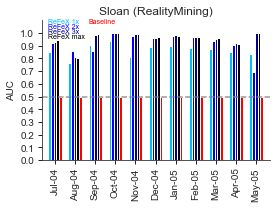

In [12]:
from matplotlib.backends.backend_pdf import PdfPages

alpha_empirical = 0.4

%matplotlib inline
nbins = 45
f, (ax1) = plt.subplots(1, 1, 
                             sharey=False, sharex=False,
                            figsize=(4, 3))
plt.setp(ax1, xticks=[ 0. ,  1.5,  3. ,  4.5,  6. ,  7.5,  9. , 10.5, 12. , 13.5, 15. ], 
         xticklabels=x_labels)
plt.setp(ax1.get_xticklabels(), rotation=90)

#ax1.set_xticks([0,0.25, 0.5, 0.75, 1])
ax1.minorticks_on()
ax1.tick_params('both', length=4, width=1, which='major', left=1, bottom=1, top=0, right=0)
plt.axhline(0.5, color='gray', linestyle='--', alpha = 0.5)


w = 1.5
width = 0.2
ax1.bar(np.array(range(len(acc_generic)))*w+0.4,auc_generic, color = 'red', #alpha = 0.5,
        #align = 'right',
       width = width, edgecolor = 'white')

ax1.bar(np.array(range(len(df_results)))*w-0.4,df_results.iter_type_auc_1, color = 'deepskyblue',# alpha = 0.5,
       # align = 'center',
       width = width, edgecolor = 'white')
ax1.bar(np.array(range(len(df_results)))*w-0.2,df_results.iter_type_auc_2, color = 'blue', #alpha = 0.5,
       # align = 'center',
       width = width, edgecolor = 'white')
ax1.bar(np.array(range(len(df_results)))*w-0,df_results.iter_type_auc_3, color = 'darkblue', #alpha = 0.5,
       # align = 'center',
       width = width, edgecolor = 'white')
ax1.bar(np.array(range(len(df_results)))*w+0.2,df_results.iter_type_auc_100, color = 'black', #alpha = 0.5,
       # align = 'center',
       width = width, edgecolor = 'white')
ax1.set_ylabel('AUC')
#ax1.set_xlabel(np.array(range(len(acc_generic)))*w,
#           x_labels[0:11],
#          rotation = 90)
ax1.set_xlim(-1,np.max(np.array(range(len(acc_generic)))*w)+1)
ax1.set_ylim(0,1.1)
plt.yticks(np.arange(0,1.1,0.1))
ax1.spines["right"].set_visible(False)
ax1.spines["top"].set_visible(False)
ax1.set_xlim(-1,16)


ax1.annotate('ReFeX 1x', xy=(-0.5,1.08), 
                 color='deepskyblue', alpha=1, size=7)
ax1.annotate('ReFeX 2x', xy=(-0.5,1.08-0.04), 
                 color='blue', alpha=1, size=7)
ax1.annotate('ReFeX 3x', xy=(-0.5,1.08-0.04*2), 
                 color='darkblue', alpha=1, size=7)
ax1.annotate('ReFeX max', xy=(-0.5,1.08-0.04*3), 
                 color='black', alpha=1, size=7)
ax1.annotate('Baseline', xy=(2.5,1.08), 
                 color='red', alpha=1, size=7)

if class_type == 'sloan':
    plt.title('Sloan (RealityMining)')
#plt.show()
print class_type
print 'undersample: ', undersample
plt.tight_layout()
plt.axhline(0.5, color='gray', linestyle='--', alpha = 0.5)


if class_type == 'sloan':
    if undersample:
        pp = PdfPages('../../figs/NEWsloan_refex_AUC_undersample_simods.pdf')
    else:
        pp = PdfPages('../../figs/NEWsloan_refex_AUC_final_simods.pdf')
pp.savefig()
pp.close()

### Accuracy

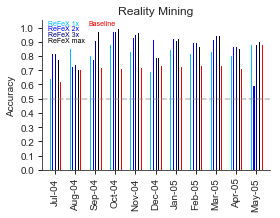

sloan
undersample:  False


In [13]:
from matplotlib.backends.backend_pdf import PdfPages

alpha_empirical = 0.4

%matplotlib inline
nbins = 45
f, (ax1) = plt.subplots(1, 1, 
                             sharey=False, sharex=False,
                            figsize=(4, 3))
plt.setp(ax1, xticks=[ 0. ,  1.5,  3. ,  4.5,  6. ,  7.5,  9. , 10.5, 12. , 13.5, 15. ], 
         xticklabels=x_labels)
plt.setp(ax1.get_xticklabels(), rotation=90)

#ax1.set_xticks([0,0.25, 0.5, 0.75, 1])
ax1.minorticks_on()
ax1.tick_params('both', length=4, width=1, which='major', left=1, bottom=1, top=0, right=0)

w = 1.5
width = 0.15
ax1.bar(np.array(range(len(acc_generic)))*w+0.4,acc_generic, color = 'red', #alpha = 0.5,
        #align = 'right',
       width = width, edgecolor = 'white')

ax1.bar(np.array(range(len(df_results)))*w-0.4,df_results.iter_type_1, color = 'deepskyblue',# alpha = 0.5,
       # align = 'center',
       width = width, edgecolor = 'white')
ax1.bar(np.array(range(len(df_results)))*w-0.2,df_results.iter_type_2, color = 'blue', #alpha = 0.5,
       # align = 'center',
       width = width, edgecolor = 'white')
ax1.bar(np.array(range(len(df_results)))*w-0,df_results.iter_type_3, color = 'darkblue', #alpha = 0.5,
       # align = 'center',
       width = width, edgecolor = 'white')
ax1.bar(np.array(range(len(df_results)))*w+0.2,df_results.iter_type_100, color = 'black', #alpha = 0.5,
       # align = 'center',
       width = width, edgecolor = 'white')
ax1.set_ylabel('Accuracy')
ax1.set_xlim(-1,np.max(np.array(range(len(acc_generic)))*w)+1)
ax1.set_ylim(0,1.05)
plt.yticks(np.arange(0,1.1,0.1))
ax1.spines["right"].set_visible(False)
ax1.spines["top"].set_visible(False)
ax1.set_xlim(-1,16)


ax1.annotate('ReFeX 1x', xy=(-0.5,1.02), 
                 color='deepskyblue', alpha=1, size=7)
ax1.annotate('ReFeX 2x', xy=(-0.5,1.02-0.04), 
                 color='blue', alpha=1, size=7)
ax1.annotate('ReFeX 3x', xy=(-0.5,1.02-0.04*2), 
                 color='darkblue', alpha=1, size=7)
ax1.annotate('ReFeX max', xy=(-0.5,1.02-0.04*3), 
                 color='black', alpha=1, size=7)
ax1.annotate('Baseline', xy=(2.5,1.02), 
                 color='red', alpha=1, size=7)
plt.tight_layout()
plt.axhline(0.5, color='gray', linestyle='--', alpha = 0.5)


plt.title('Reality Mining')
plt.show()
print class_type
print 'undersample: ', undersample

# Within-Network 

See other notebook.